In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import pickle

from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import roc_curve, roc_auc_score, auc, mean_squared_error, confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, VotingClassifier

def return_plot(estimator, plot=False):
    df['Returns'] = df.Close.pct_change()
    df['Predicted_Signal'] = estimator.predict(X)
    Cumulative_returns = np.cumsum(df[split:]['Returns'])
    df['Startegy_returns'] = df['Returns']* df['Predicted_Signal'].shift(1)
    Cumulative_Strategy_returns = np.cumsum(df[split:]['Startegy_returns'])
    print('Return: {}%'.format(round(Cumulative_Strategy_returns[-1] * 100), 2))
    
    if plot:
        plt.figure(figsize=(10,5))
        plt.plot(Cumulative_returns, color='r',label = 'Returns')
        plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')
        plt.legend()
        plt.show()

def roc_plot(estimator, auc_cv=False, title="ROC Curve"):
    X_ = X_test
    y_ = y_test
    y_pred = estimator.predict(X_)
    y_pred_prob = estimator.predict_proba(X_)[:,1]
    #y_pred_prob = y_pred
    fpr, tpr, thresholds = roc_curve(y_, y_pred_prob)
    print('Train Score: {}%'.format(round(estimator.score(X_train, y_train)*100, 2)))
    print("Test Score: {}%".format(round(estimator.score(X_, y_)*100, 2)))
    print(confusion_matrix(y_, y_pred))
    print(classification_report(y_, y_pred))

    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.show()

    #If the AUC is greater than 0.5, the model is better than random guessing. Always a good sign!
    print("AUC: {}%".format(round(roc_auc_score(y_, y_pred_prob)*100, 2)))
    
    if (auc_cv):
        cv_auc = cross_val_score(estimator, X, y, cv=5, scoring='roc_auc', n_jobs=-1)
        print("AUC scores computed using 5-fold cross-validation: {}%".format(round(np.mean(cv_auc)*100, 2)))
  

df = pd.read_csv('data1.csv', index_col='Datetime')
y = df.Target.values
X = df.drop(['Target', 'Close'], axis=1).values

split = int(len(df) * 0.60)
X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]

print('X shape {}'.format(X_train.shape))

X shape (2904, 7)


Fitting 5 folds for each of 55296 candidates, totalling 276480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 8993 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 28493 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 55793 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done 90893 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done 133793 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 184493 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 242993 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 276480 out of 276480 | elapsed:  3.0min finished


Train Score: 51.41%
Test Score: 50.52%
[[ 51 927]
 [ 31 927]]
              precision    recall  f1-score   support

          -1       0.62      0.05      0.10       978
           1       0.50      0.97      0.66       958

   micro avg       0.51      0.51      0.51      1936
   macro avg       0.56      0.51      0.38      1936
weighted avg       0.56      0.51      0.37      1936



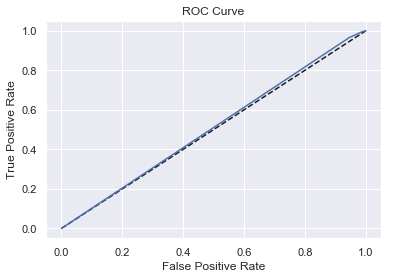

AUC: 50.99%


NameError: name 'dec' is not defined

In [2]:
params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': np.arange(1,10),
    'min_samples_split': np.arange(2,5),
    'min_samples_leaf': np.arange(1,5),
    #'min_weight_fraction_leaf': np.logspace(-4, 4, 20),
    'max_features': ['auto', 'sqrt', 'log2', None],
    'max_leaf_nodes': np.arange(2,10),
    #'max_impurity_decrease': np.logspace(-4, 4, 20),
    #'min_impurity_split': np.logspace(-4, 4, 20),
    'class_weight': [None, 'balanced'],
    'presort': [True, False]
}
dec_cv = GridSearchCV(DecisionTreeClassifier(), params, cv=5, n_jobs=-1, verbose=1)
dec_cv.fit(X_train, y_train)
roc_plot(dec_cv)
return_plot(dec_cv, plot=True)

Train Score: 100.0%
Test Score: 48.4%
[[440 538]
 [461 497]]
              precision    recall  f1-score   support

          -1       0.49      0.45      0.47       978
           1       0.48      0.52      0.50       958

   micro avg       0.48      0.48      0.48      1936
   macro avg       0.48      0.48      0.48      1936
weighted avg       0.48      0.48      0.48      1936



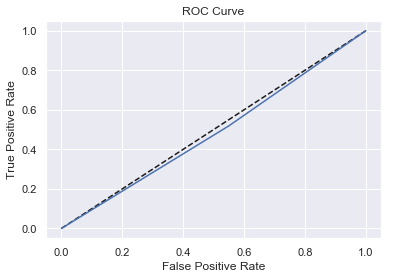

AUC: 48.43%
Return: -26.0%


In [7]:
dec_pipe = Pipeline([
    ('poly', PolynomialFeatures()),
    ('scaler', StandardScaler()),
    ('dec', DecisionTreeClassifier())
]).fit(X_train, y_train)
roc_plot(dec_pipe)
return_plot(dec_pipe)